# **Homework 2-Steam Reviews 2021**
## **Research Questions**

### [RQ1] Exploratory data analysis

In [ ]:
!pip3 install --upgrade pip
!pip install kaggle

In [ ]:
!pip3 install --upgrade pandas

In [ ]:
!kaggle datasets download -d najzeko/steam-reviews-2021

In [ ]:
!unzip steam-reviews-2021.zip

In [ ]:
!pip3 install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats

In [2]:
# We will use the parser seen during lectures 
def dateparse(time_in_secs):
    return pd.to_datetime(time_in_secs, unit='s')

In [10]:
dataset = pd.read_csv('./steam_reviews.csv', header='infer')

The dataset we are going to work on is composed of 22 features (excluding the index feature):
+ **app_id** and **app_name** both refer to the reviewed application, in a coded and namely fashion.
+ **review_id**, **language** and **review** concern the review: it's identificative number, the language used and the review itself
+ **timestamp_created** and **timestamp_updated** are two fields that give information about the timestamps at which reviews are created or modified
+ **recommended** is a boolean variable that states whether the author recommends the game or not
+ **votes_helpful**, **votes_funny**, **weighted_vote_score** and **comment count** are numerical variables that concern the review. How many votes for "funny" or "helpful", it's overall score and the number of comments
+ **steam_purchase**, **received_for_free** and **written_during_early_access** are boolean features that refer to the acquisition of the app by the author, if purchased, received for free and if the review was written during the early access of a game
+ **author.steamid**, **author.num_games_owned**, **author.num_reviews** begin a group of variables dedicated to the author: it's id, the number of games he/she owns and the number of reviews he/she made
+ **author.playtime_forever**, **author.playtime_last_two_weeks**, **author.playtime_at_review** and **author.last_played** refer to the playtime of the author at various intervals


After having explained these features we will move to the real analysis. 

For example we might want to know how are languages distributed across the dataset

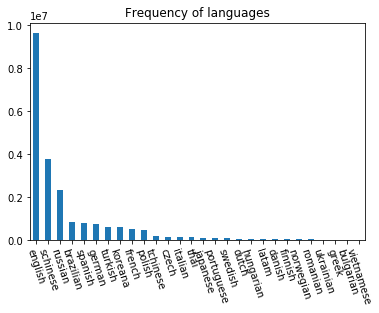

In [11]:
# take value counts, then plot
dataset.language.value_counts().plot(kind='bar',rot=-72,label=str(dataset.language),title='Frequency of languages')

Or for example it would be interesting to see if the percentage of recommended votes is higher or lower when the game is in early access

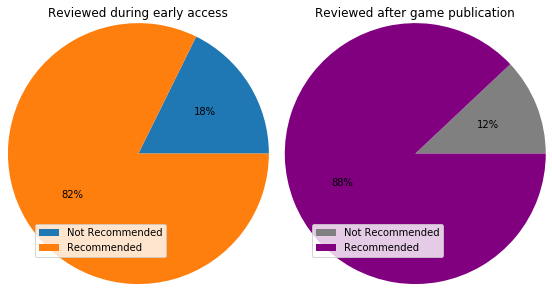

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2) 
plt.subplots_adjust(right=1.3)
ax1.set_title('Reviewed during early access',y=1.1)
ax1.pie(dataset[dataset['written_during_early_access']==True].groupby('recommended').review.count(),
        labels=['Not Recommended','Recommended'],labeldistance=None,radius=1.5,autopct='%1.0f%%')
ax1.legend()
ax2.set_title('Reviewed after game publication',y=1.1)
ax2.pie(dataset[dataset['written_during_early_access']==False].groupby('recommended').review.count(),
        labels=['Not Recommended','Recommended'],colors=['grey','purple'],labeldistance=None,radius=1.5,autopct='%1.0f%%')
ax2.legend()

As expected the percentage is -slightly- lower. This is perfectly taken into account since Early Access games are not ended yes so they may offer worse experiences to the user.

We now want to see if users tend to give more "funny" votes to reviews in constrast to "helpful"

Text(0.5, 1.0, 'number of funny votes in contrast to helpful')

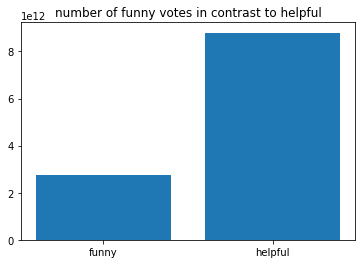

In [14]:
x = [sum(dataset.votes_funny),sum(dataset.votes_helpful)]
plt.bar(['funny','helpful'],height=x)
plt.title('number of funny votes in contrast to helpful')

Seems like steam users lack in sense of humor.
Anyway it might be interesting to see if there is a correlation between the number of comments and the number of helpful votes!

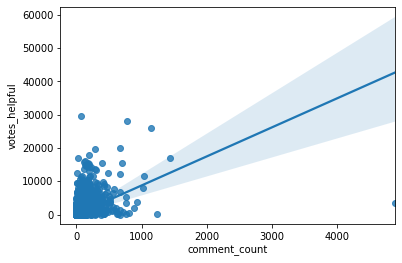

In [15]:
# we only took rows where there was a number of comments higher than zero, then we tried out regplot from the seaborn library
cc=dataset[dataset['comment_count']>0]
sns.regplot(x=cc.comment_count,y=cc.votes_helpful)

There doesn't seem to be a clear linear relationship between the two variables.

---
### [RQ2]

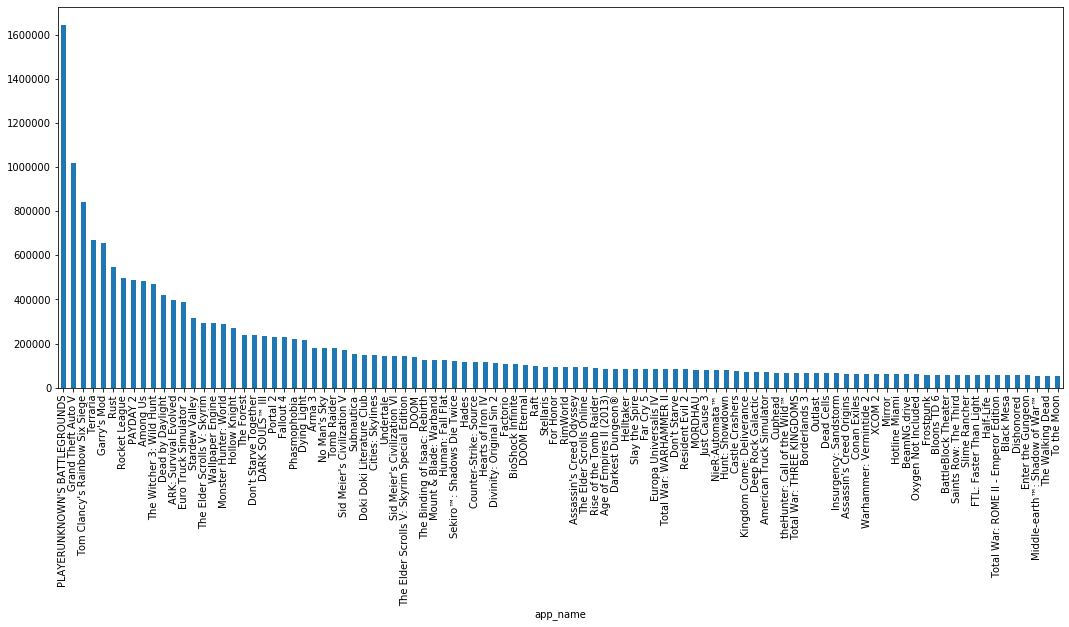

In [16]:
#1
dataset.groupby('app_name').review.count().sort_values(ascending=False)[:100].plot.bar(figsize = (18, 7))
#I grouped by "app_name", selected review column, count the rewivew for the single app and eventually plot them 
#I decided to plot just the first 100 because the plot would have become incomprehensible and after a while the values were all more or less the same

In [17]:
#2
maxScore = dataset.groupby('app_name').weighted_vote_score.mean()
topTen = maxScore.sort_values(ascending=False)
for i in range(5):
    print(topTen.index[i] , format(topTen[i],'.5f'))
#through weighted_vote_score I've done the mean. In the end I showed the 5 with the highest rating

Hunt Down The Freeman 0.50215
Urban Empire 0.43862
METAL GEAR SURVIVE 0.42163
Identity 0.41538
Umbrella Corps 0.41468


In [18]:
#3
#I grouped by "app_name", I've select just the column with recommended equal to true, selected recommended column, count 
min = dataset[dataset['recommended'] == True].groupby('app_name').recommended.count()
max = dataset[dataset['recommended'] == True].groupby('app_name').recommended.count()
print("the application with more recommendations is: ", max.idxmax(), "with",max.loc[max.idxmax()])
print("the application with fewer recommendations is: ", min.idxmin(), "with",min.loc[min.idxmin()])
#throught min and max I've showed wich application have have the most and the least recommendations

the application with more recommendations is:  PLAYERUNKNOWN'S BATTLEGROUNDS with 886417
the application with fewer recommendations is:  Neon Hardcorps with 89


In [19]:
#4
purchase = dataset[dataset['steam_purchase'] == True].groupby('app_name').steam_purchase.value_counts()
purchase_free = dataset[dataset['received_for_free'] == True].groupby('app_name').received_for_free.value_counts()
print("List of those that have been purchased", len(purchase))
print("\nList of those that have been received for free", len(purchase_free))
#I simply collected the data from the appropriate columns with the codition True that means purchase or received for free

List of those that have been purchased 313

List of those that have been received for free 315


---
### [RQ3]

In [5]:
dataset = pd.read_csv('steam_reviews.csv',header='infer',parse_dates=['timestamp_created','timestamp_updated', 'author.last_played'],date_parser=dateparse)

In [6]:
# With a simple query we isolate the feature we need, excluding the date part and with value_counts() we group the creation variable
creation = dataset.timestamp_created.dt.time
print("Most common time of writing:",creation.value_counts().index[0],"\nNumber of occurrences:", creation.value_counts()[0])

Most common time of writing: 15:54:53 
Number of occurrences: 583


In [9]:
def rev_counts(time_intervals):
    # First we ccreate the variable of interest
    hours = dataset.timestamp_created.dt.hour
    # Then a long procedure to engineer the input: parse, extract hours and sort. At last we append 24 to include reviews written between 8 pm and 12 pm
    time_intervals = pd.Series(time_intervals)
    time_intervals = pd.to_datetime(time_intervals,infer_datetime_format=True)
    time_intervals = time_intervals.dt.hour
    time_intervals = sorted(time_intervals)
    time_intervals.append(24)
    # We then bin the variable of interest with the newly created bins, group the results and plot 
    bins = pd.cut(hours,time_intervals)
    return bins.value_counts(sort=False).plot(kind='bar',title='Number of reviews by time interval',colormap='plasma',grid=True,rot=45)
    

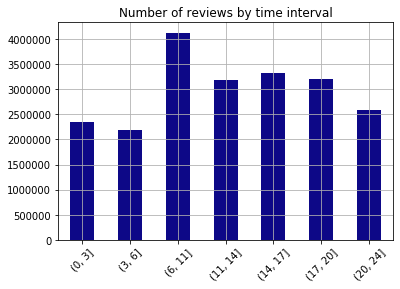

In [10]:
times = ['06:00:00','11:00:00','14:00:00','17:00:00','20:00:00','00:00:00','03:00:00']
rev_counts(times)

---
### [RQ4]

In [15]:
dataset = pd.read_csv('./steam_reviews.csv', header='infer')

In [16]:
#count how many time each languge appear
top_language = dataset.loc[:,'language'].value_counts()
#sort it and take the 3 largest
top_language = top_language[:3].sort_values(ascending=False)
print('the 3 top language are :',*top_language.index.array)

the 3 top language are : english schinese russian


In [17]:
def language_fillter(dataset, languages):
    #create a new pd with the same column as the original
    cmlg = pd.DataFrame(columns=dataset.columns.values) 
    for lg in languages:
        # add one of the language to the new pd 
        cmlg = cmlg.append(dataset[dataset.language == lg])
    return cmlg
#use the new method with the top 3 language
tr = language_fillter(dataset, top_language.index.array)        

In [18]:
# remove the vote that are not funny
result = tr[tr.votes_funny > 0]
print('The percentage of funny vote in this 3 language is:',str((len(result)/len(tr))*100)+'%')

The percentage of funny vote in this 3 language is: 12.208323618618321%


In [19]:
# remove the vote that are not helpful
result = tr[tr.votes_helpful > 0]
print('The percentage of helpful vote in this 3 language is:',str((len(result)/len(tr))*100)+'%')

The percentage of helpful vote in this 3 language is: 29.162723635279374%


---
### [RQ5]

In [16]:
#1
df = dataset.groupby('author.steamid')['author.num_reviews'].sum() 
df.sort_values(ascending=False).head(10)
#for each author I have added up the number of revisions they have made, I've used author.steamid because it is the only identification code, maybe for privacy

author.steamid
76561198103272004    4398046511108
76561198848008157    4398046511105
76561198045381877           244662
76561198062813911           241529
76561197960373660           202713
76561198094803808           196877
76561197974092119           190141
76561198013146396           189568
76561198043049777           170072
76561198116879965           163030
Name: author.num_reviews, dtype: int64

In [17]:
#2
mostPopularAuthor = df.sort_values(ascending=False).head(10).idxmax() # I get the name of the famouse author, which for me is the person who has done the most reviews 
pd.set_option('display.max_rows', None) #this setting helps us to see all data 
dataset[dataset['author.steamid'] == mostPopularAuthor].app_name.head() # I show the list of apps that the popular author has commented that he has commented
#the first line that you see is just the id of the position in the dataset

13093694    Grand Theft Auto V
Name: app_name, dtype: object

In [18]:
#3
countNumber = dataset[(dataset['author.steamid'] == mostPopularAuthor)].steam_purchase.value_counts() #how many application the most popular author purchase
perctNumber = dataset[(dataset['author.steamid'] == mostPopularAuthor)].steam_purchase.value_counts(normalize=True) * 100 ##the same but in percentage
if(True in countNumber): #it is used to prevent errors when a value is null
    countNumber = countNumber.loc[countNumber.index == True].item()
    perctNumber = perctNumber.loc[perctNumber.index == True].item()
else:
    countNumber = 0
    perctNumber = 0
print('number of applications purchased : ', countNumber , 'in percentage', format(perctNumber, '.2f') , '%')

countNumber = dataset[(dataset['author.steamid'] == mostPopularAuthor)].received_for_free.value_counts()#the same as before 
perctNumber = dataset[(dataset['author.steamid'] == mostPopularAuthor)].received_for_free.value_counts(normalize=True) * 100 #idem
if(True in countNumber):
    countNumber = countNumber.loc[countNumber.index == True].item()
    perctNumber = perctNumber.loc[perctNumber.index == True].item()
else:
    countNumber = 0
    perctNumber = 0
print('number of applications purchased for free: ', countNumber , 'in percentage', format(perctNumber, '.2f') , '%')



number of applications purchased :  1 in percentage 100.00 %
number of applications purchased for free:  0 in percentage 0.00 %


In [19]:
#4
reviewNumber = dataset[(dataset['author.steamid'] == mostPopularAuthor)].recommended.value_counts() #I filtered the dataset by the author name
if(True in reviewNumber.loc[reviewNumber.index == True]): #with these if we show the positive and negative reviews
    positive = reviewNumber.loc[reviewNumber.index == True].item()
else:
    positive = 0
if(False in reviewNumber.loc[reviewNumber.index == False]):
    negative = reviewNumber.loc[reviewNumber.index == False].item()
else:
    negative = 0

print('of the applications purchased', positive ,'was/were positively reviewed \n')
print('of the applications purchased', negative ,'was/were negatively reviewed')

of the applications purchased 1 was/were positively reviewed 

of the applications purchased 0 was/were negatively reviewed


Is very strange, it means that our mostPopularAuthor only made reviews on Grand Theft Auto V!


---
### [RQ6]

In [31]:
dataset = pd.read_csv('steam_reviews.csv', header='infer',usecols = ['timestamp_created', 'timestamp_updated', 'author.steamid'])

In [32]:
# remove all the review that have not been update
dataset = dataset[dataset.timestamp_updated > dataset.timestamp_created]
#calculate the diff between the original and his update
dataset['delta'] = dateparse(dataset['timestamp_updated']) - dateparse(dataset['timestamp_created'])
print('The average time between a review and is update is:',dataset['delta'].mean())

The average time between a review and is update is: 321 days 00:46:36.172308


In [33]:
# find the top author (all the row have review update)
top_authors = dataset.loc[:,'author.steamid'].value_counts()
top_authors = top_authors[:3].sort_values(ascending=False)
li = top_authors.index.array

In [34]:
# select the row that belong to the top 3 author
for i in range(len(li)):
    tr = dataset[dataset['author.steamid'] == li[i]]['delta'].mean()
    print(f'the id of the author is:{li[i]} he as update {top_authors.array[i]} of his review with on average {tr} times')

the id of the author is:76561198192166873 he as update 95 of his review with on average 407 days 13:37:26.357894 times
the id of the author is:76561198206999976 he as update 61 of his review with on average 315 days 10:36:47.032786 times
the id of the author is:76561198072450805 he as update 60 of his review with on average 742 days 11:44:30.283333 times


---
### [RQ7]

In [20]:
# We just query the results and sum the boolean values.
print("The probability is equal to:",sum(dataset.weighted_vote_score >= 0.5) / len(dataset.weighted_vote_score))


The probability is equal to: 0.21998484322541792


---
So the probability of the event "a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5" given that it is a conditioned prob is equal to: 
> $P(Exists  funny | wvs > 0.5)=\frac{P(Exists  funny, wvs > 0.5)}{P(wvs > 0.5)}$ 

where wvs is weighted_vote_score


In [21]:
# P(wvs > 0.5)
P_denom = sum(dataset.weighted_vote_score > 0.5) / len(dataset.weighted_vote_score)

# P(Exists funny, wvs > 0.5)
tmp = dataset[dataset['weighted_vote_score'] > 0.5]
event = sum(tmp.votes_funny > 0)
P_num = event / len(dataset)
# Then we compute P(Exist funny | wvs > 0.5)
print("Probability that a review that has a wvs bigger than 0.5 has also at least one vote as funny:", P_num/P_denom)

Probability that a review that has a wvs bigger than 0.5 has also at least one vote as funny: 0.24978288914523247


In order to look for independence between 2 events we need to compute the probability of the intersection of these events and if it's equal to the product of the probability of these events then we have independence.
> $P(A \cap B) = P(A)P(B)$

In [22]:
# as such we already did some of these calculations before
# P(wvs > 0.5) is  P_denom
# P(Exists funny, wvs > 0.5) is P_num
# we need P(Exists funny)
P_EF = sum(dataset.votes_funny > 0)/len(dataset)
print("Q: Are these events independent?\nA:",P_num==P_denom*P_EF)

Q: Are these events independent?
A: False


looks like they aren't :(

---
### [RQ8]

In order to test whether the values from the two groupings of the weighted vote score variable come from the same population when we group chinese and russian reviews we want to run a Mann-Whitney test between the two vectors. First we extract these datasets and then we proceed with the analysis thanks to the scipy library 

In [23]:
# data extraction
Rus = dataset[dataset['language']=='russian']
Chi = dataset[dataset['language']=='schinese']

In [24]:
# we run the test and look whether the p-value is bigger than
output = scipy.stats.mannwhitneyu(Rus.weighted_vote_score,Chi.weighted_vote_score,alternative='two-sided')
print("p-value for the U test",output.pvalue)

p-value for the U test 0.0


As expected the two variables have a p-value below 0.05, so we reject the null hypothesis that the two samples come from the same population, for further discussion we will now plot the histograms of the two variables

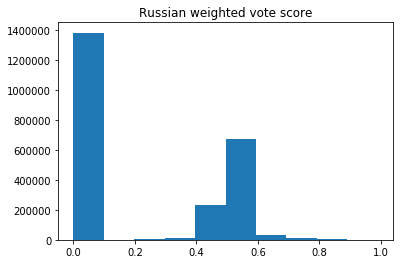

In [25]:
plt.hist(Rus.weighted_vote_score)
plt.title('Russian weighted vote score')
plt.show()

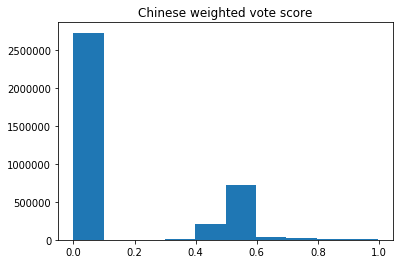

In [26]:
plt.hist(Chi.weighted_vote_score)
plt.title('Chinese weighted vote score')
plt.show()

Now, we want to see if there is a relationship between the variables weighted vote score and the time delta between the posting and updating of a review. To do so we look for a summary statistics as the correlation and then we might also try to fit a linear regression model to explain the wvs from the time delta.

In [27]:
# feature extraction
timedelta = dataset.timestamp_updated-dataset.timestamp_created
wvs = dataset.weighted_vote_score
# Correlation computation
cor = scipy.stats.pearsonr(wvs,timedelta)
print("Pearson's correlation coefficent is:",cor[0])

Pearson's correlation coefficent is: 0.0720470056230728


In [28]:
# This coefficient seems very low, we might want to try a linear model
from sklearn.linear_model import LinearRegression
import numpy as np

In [29]:
timedelta = np.array(timedelta)
wvs = np.array(wvs)
model = LinearRegression()
# reshape data
model.fit(timedelta.reshape(-1,1),wvs)
slope = model.coef_
intercept = model.intercept_ 
model.score(timedelta.reshape(-1,1),wvs)

0.005190771019246476

The R squared for the regression model is very close to zero, signaling no definite relasionship between the two vectors, to further analyze this we plot the data with a scatterplot and add a red line for the regression.

In [30]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',lw=3,color='red')

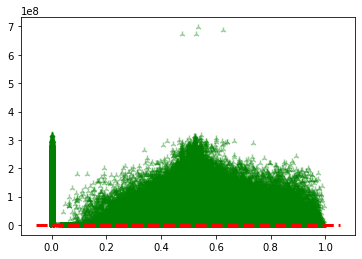

In [31]:
plt.scatter(wvs,timedelta, marker='2', cmap='plasma',alpha=0.4,color='green')
abline(slope,intercept)
plt.show()

As we can see the line does not fit the data at all and there is no identifiable pattern in the data.

To see if there is a substantial change when we divide the dataset in recommended and not recommended review we do the following

In [32]:
# sub-setting
recom = dataset[dataset['recommended']==True]
not_recom = dataset[dataset['recommended']!=True]

#### Recommended

In [33]:
# feature extraction
timedelta = recom.timestamp_updated-recom.timestamp_created
wvs = recom.weighted_vote_score
# Correlation computation
cor = scipy.stats.pearsonr(wvs,timedelta)
print("Pearson's correlation coefficent is:",cor[0])

Pearson's correlation coefficent is: 0.07948251790959787


In [34]:
# This coefficient seems very low, we might want to try a linear model
from sklearn.linear_model import LinearRegression
import numpy as np

In [35]:
timedelta = np.array(timedelta)
wvs = np.array(wvs)
model = LinearRegression()
# reshape data
model.fit(timedelta.reshape(-1,1),wvs)
slope = model.coef_
intercept = model.intercept_ 
model.score(timedelta.reshape(-1,1),wvs)

0.006317470653247947

#### Not Recommended

In [36]:
# feature extraction
timedelta = not_recom.timestamp_updated-not_recom.timestamp_created
wvs = not_recom.weighted_vote_score
# Correlation computation
cor = scipy.stats.pearsonr(wvs,timedelta)
print("Pearson's correlation coefficent is:",cor[0])

Pearson's correlation coefficent is: -0.0017771848851912773


In [37]:
# This coefficient seems very low, we might want to try a linear model
from sklearn.linear_model import LinearRegression
import numpy as np

In [38]:
timedelta = np.array(timedelta)
wvs = np.array(wvs)
model = LinearRegression()
# reshape data
model.fit(timedelta.reshape(-1,1),wvs)
slope = model.coef_
intercept = model.intercept_ 
model.score(timedelta.reshape(-1,1),wvs)

3.158386115975631e-06

There appears to be not much difference between the results, the R squared is still very low even considering only recommended or not recommended reviews, so apparently there is no relationship between the variables.

# [TQ2]

EXERCISE 1

![Cat](images/TQ1_1.jpg)

![Cat](images/TQ1_2.jpg)

![Cat](images/TQ1_3.jpg)

![Cat](images/TQ1_4.jpg)

EXERCISE 2

![Cat](images/TQ2_1.jpg)

![Cat](images/TQ2_2.jpg)

![Cat](images/TQ2_3.jpg)

![Cat](images/TQ2_4.jpg)

# [TQ3]

In the knapsack problem we are given n objects and each object i has a weight $w_i$ and a value $v_i$. We are also given a weight budget W. The problem is to select a set of objects with total weight bounded by W that maximized the sum of their values. The following are three natural heuristics: <br />

For each of the heuristics, provide a counterexample, that is, an example of a problem instance in which the heuristic fails to provide the optimal solution. <br />

The solution will be provide you to array v and w who represent respectively all the value of $w_i$ and $v_i$ this arrays will already be order according to the criteria of the heuristic. After that the weight bounded will be indicated as $w_B$. And finally we will display the result of the heuristic in comparaison of the optimal solution.



## 1 
Order them in increasing order of weight and then visit them sequentially, adding them to the solution as long as the budget is not exceeded <br />
    v = [1, 1, 10] <br />
    w = [2, 3, 6] <br />
    $w_B$ = 6 <br />
    heuristic = 2 < optimal = 10 <br />
## 2
Order them in decreasing order of values, and then visit them sequentially, adding them to the solution if the budget is not exceeded
<br />
    v = [7, 6, 5] <br />
    w = [6, 2, 4] <br />
    $w_B$ = 6 <br />
    heuristics = 7 < optimal = 11 <br />
## 3
Order them in decreasing relative value (v_i / w_i), and then visit them sequentially, adding them to the solution if the budget is not exceeded
<br />
    v = [1, 1, 5] <br />
    w = [1, 1, 6] <br />
    $w_B$ = 6 <br />
    heuristics = 2 < optimal = 5 <br />